##  OOI ADCP Preprocessing

This notebook accesses a continuous stretch of ADCP data which has already been converted to `zarr` format and stored in Don Setiawan's `ooi-data` bucket. Information about the datasets can be found on the [Interactive Oceans Website](https://app.interactiveoceans.washington.edu/instrument-information).

The notebook performs several preprocessing steps:

* access a time period of mostly continuous time series
* for each month in this time period
    * resample to smaller resolution
    * regrid on a regular grid
    * rechunk on a daily scale
    * store the result in a `.zarr` store 
    
* the collection of `.zarr` stores then can be open as one `xarray`

### Accessing Data On Cloud Storage

Based on the work of Derya Gumustel, we select a stretch that overlaps with echosounder data, and set the corresponding path in the S3 bucket.

In [18]:
S3_PATH = 's3://ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/'

In [19]:
# conda install --yes s3fs

In [20]:
# conda install --yes zarr -c conda-forge

In [21]:
# conda install --yes xarray -c conda-forge

In [22]:
# conda install --yes netcdf4

In [23]:
# conda install --yes nc-time-axis -c conda-forge

In [24]:
# conda install --yes matplotlib

In [25]:
import s3fs

In [26]:
import os

In [27]:
from glob import glob

In [28]:
import xarray as xr

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
s3 = s3fs.S3FileSystem(anon=True)

In [14]:
zarr_files = s3.ls(S3_PATH)

In [15]:
zarr_files

['ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/.zattrs',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/.zgroup',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/.zmetadata',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/bin',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/bin_1_distance',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/bin_depths',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/cell_length',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/corrected_echo_intensity_beam1',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/corrected_echo_intensity_beam2',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/corrected_echo_intensity_beam3',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-adcp_velocity_beam/corrected_echo_intensity_beam4',
 'ooi-data/CE02SHBP-LJ01D-05-ADCPTB104-streamed-

In [ ]:
store = s3fs.S3Map(root=S3_PATH, s3=s3, check=False)

In [17]:
ds = xr.open_zarr(store=store, consolidated=True)

In [18]:
ds.dims

Frozen({'bin': 22, 'time': 279768062})

In [19]:
ds

<xarray.Dataset>
Dimensions:                         (bin: 22, time: 279768062)
Coordinates:
  * bin                             (bin) int32 0 1 2 3 4 5 ... 17 18 19 20 21
  * time                            (time) datetime64[ns] 2014-09-25T18:10:07...
Data variables: (12/51)
    bin_1_distance                  (time) float32 dask.array<chunksize=(25000000,), meta=np.ndarray>
    bin_depths                      (time, bin) float64 dask.array<chunksize=(560000, 22), meta=np.ndarray>
    cell_length                     (time) float32 dask.array<chunksize=(25000000,), meta=np.ndarray>
    corrected_echo_intensity_beam1  (time, bin) float64 dask.array<chunksize=(560000, 22), meta=np.ndarray>
    corrected_echo_intensity_beam2  (time, bin) float64 dask.array<chunksize=(560000, 22), meta=np.ndarray>
    corrected_echo_intensity_beam3  (time, bin) float64 dask.array<chunksize=(560000, 22), meta=np.ndarray>
    ...                              ...
    transducer_depth                (time) float32 dask.array<chunksize=(25000000,), meta=np.ndarray>
    upward_seawater_velocity        (time, bin) float64 dask.array<chunksize=(560000, 22), meta=np.ndarray>
    velocity_beam1                  (time, bin) float32 dask.array<chunksize=(1100000, 22), meta=np.ndarray>
    velocity_beam2                  (time, bin) float32 dask.array<chunksize=(1100000, 22), meta=np.ndarray>
    velocity_beam3                  (time, bin) float32 dask.array<chunksize=(1100000, 22), meta=np.ndarray>
    velocity_beam4                  (time, bin) float32 dask.array<chunksize=(1100000, 22), meta=np.ndarray>
Attributes: (12/64)
    AssetManagementRecordLastModified:  2022-05-02T18:38:13.474000
    AssetUniqueID:                      ATOSU-69826-00001
    Conventions:                        CF-1.6
    Description:                        ADCP Velocity Profiler (short range):...
    FirmwareVersion:                    Not specified.
    Manufacturer:                       Teledyne RDI
    ...                                 ...
    stream:                             adcp_velocity_beam
    subsite:                            CE02SHBP
    summary:                            Dataset Generated by Stream Engine fr...
    time_coverage_end:                  2022-05-06T06:06:07.282959872
    time_coverage_start:                2014-09-25T18:10:07.729999872
    title:                              Data produced by Stream Engine versio...

### Processing One Segment

Since the size of this dataset is big (over 279 million time stamps! and a total of 54GB) , it is easier to process it through a function which works only on segments.

In [21]:
def segment2zarr(da, start_time, end_time, sampling_res, name, output_path):
    """a function to read the data for a time segment,
        downsample and output the downsampled version to zarr
        
        da: xarray DataArray
        start_time
        end_time
        sampling_res: DataOffset str for example "30D", "1min"
        name: the name of the downsampled array
        output_path: the directory to store the zarr (the actual zarr name is based on the timestamp)
        
        Note the chunk size is calculated to be a day. 
        There will be some issues if the segment is shorter than a day.
    """
    # getting segment
    da_segment = da.sel(time=slice(start_time, end_time))
    
    # downsampling
    da_resampled = da_segment.resample(time=sampling_res).mean()
    
    # gridding
    time_grid = pd.date_range(start=start_time, end=end_time, freq=sampling_res, closed='left')

    da_gridded = da_resampled.reindex(time=time_grid)
    
    # rechunking to daily chunk (this will not work if segment is less than a day)
    n_days = (end_time - start_time)/np.timedelta64(1, 'D')
    chunk_size = round(len(time_grid)/n_days)
    da_gridded = da_gridded.chunk((chunk_size,), (da_resampled.shape[1],))
    
    # writing to zarr
    da_gridded.to_dataset(name=name).to_zarr(output_path)

In [22]:
# the path to store the zarr files (in this case it is on the mounted elastic file storage)
zarr_path =  "../../efs/ADCP_zarr/"

In [23]:
rm -r /home/ubuntu/efs/ADCP_zarr/2015-08-01T08:00:00.000000000.zarr

In [24]:
start_time = np.datetime64('2015-08-01T00:00:00.000000000-0800')
dt = np.timedelta64(30, 'D')

<ipython-input-24-9b8d6fdb7fc0>:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  start_time = np.datetime64('2015-08-01T00:00:00.000000000-0800')


We will access the `corrected_echo_intensity_beam1` variable.

In [25]:
%%time
segment2zarr(ds.corrected_echo_intensity_beam1, 
             start_time=start_time, 
             end_time=start_time + dt,
             sampling_res="1min",
             name='corrected_echo_intensity_beam1', 
             output_path=os.path.join(zarr_path, str(start_time)+".zarr"))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 2min 51s, sys: 16.3 s, total: 3min 7s
Wall time: 2min 44s


In [26]:
da_processed = xr.open_dataset(os.path.join(zarr_path, str(start_time)+".zarr"))

/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


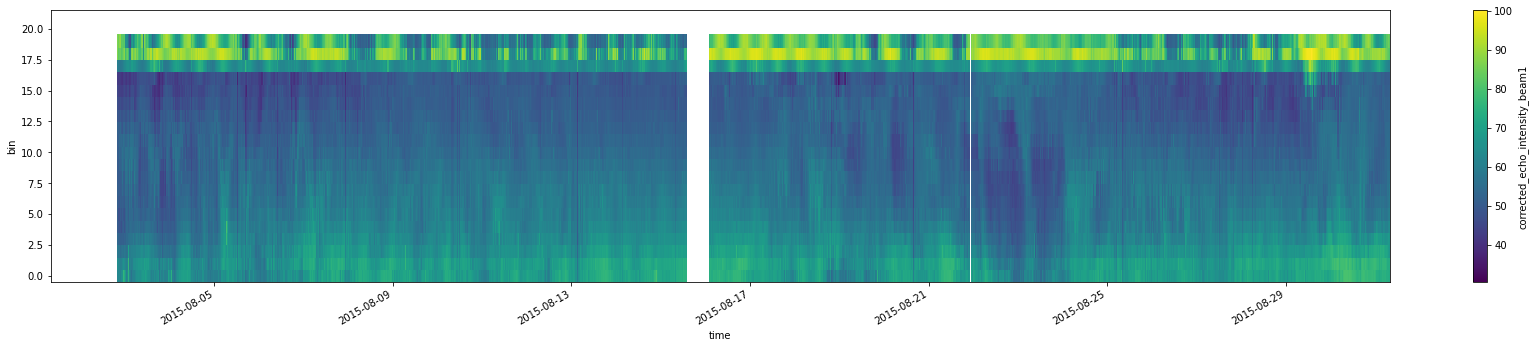

In [27]:
plt.figure(figsize=(30, 5))
da_processed.corrected_echo_intensity_beam1.T.plot()

In [28]:
da_processed

<xarray.Dataset>
Dimensions:                         (bin: 22, time: 43200)
Coordinates:
  * bin                             (bin) int32 0 1 2 3 4 5 ... 17 18 19 20 21
  * time                            (time) datetime64[ns] 2015-08-01T08:00:00...
Data variables:
    corrected_echo_intensity_beam1  (time, bin) float64 ...

### Processing All Data

In [29]:
rm -r /home/ubuntu/efs/ADCP_zarr/*

In [30]:
# generate 30D segment intervals for the time period
# 2015-08-01T00:00:00.000000000 - 2017-09-30T00:00:00.000000000 (offset by 8 hours from UTC)
segment_intervals = pd.interval_range(start=np.datetime64('2015-08-01T00:00:00.000000000-0800'),
                  end=np.datetime64('2017-09-30T00:00:00.000000000-0800'), 
                  freq="30D")

<ipython-input-30-94a8297385b3>:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  segment_intervals = pd.interval_range(start=np.datetime64('2015-08-01T00:00:00.000000000-0800'),
<ipython-input-30-94a8297385b3>:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  end=np.datetime64('2017-09-30T00:00:00.000000000-0800'),


In [31]:
%%time
# loop through all
for interval in segment_intervals:
    segment2zarr(ds.corrected_echo_intensity_beam1, 
             start_time=interval.left, 
             end_time=interval.right,
             sampling_res="1min",
             name='corrected_echo_intensity_beam1', 
             output_path=os.path.join(zarr_path, str(interval.left)+".zarr")) 



/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x

CPU times: user 1h 5min 5s, sys: 5min 25s, total: 1h 10min 31s
Wall time: 1h 1min 53s


### Reading Processed Data

In [31]:
ls /home/ubuntu/efs/ADCP_zarr/

'2015-08-01 08:00:00.zarr'/  '2016-08-25 08:00:00.zarr'/
'2015-08-31 08:00:00.zarr'/  '2016-09-24 08:00:00.zarr'/
'2015-09-30 08:00:00.zarr'/  '2016-10-24 08:00:00.zarr'/
'2015-10-30 08:00:00.zarr'/  '2016-11-23 08:00:00.zarr'/
'2015-11-29 08:00:00.zarr'/  '2016-12-23 08:00:00.zarr'/
'2015-12-29 08:00:00.zarr'/  '2017-01-22 08:00:00.zarr'/
'2016-01-28 08:00:00.zarr'/  '2017-02-21 08:00:00.zarr'/
'2016-02-27 08:00:00.zarr'/  '2017-03-23 08:00:00.zarr'/
'2016-03-28 08:00:00.zarr'/  '2017-04-22 08:00:00.zarr'/
'2016-04-27 08:00:00.zarr'/  '2017-05-22 08:00:00.zarr'/
'2016-05-27 08:00:00.zarr'/  '2017-06-21 08:00:00.zarr'/
'2016-06-26 08:00:00.zarr'/  '2017-07-21 08:00:00.zarr'/
'2016-07-26 08:00:00.zarr'/  '2017-08-20 08:00:00.zarr'/


In [32]:
zarr_stores = glob('/home/ubuntu/efs/ADCP_zarr/*')

In [33]:
da_processed = xr.open_mfdataset(zarr_stores)

/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/ubuntu/anaconda3/lib/python3.8/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/ubuntu/a

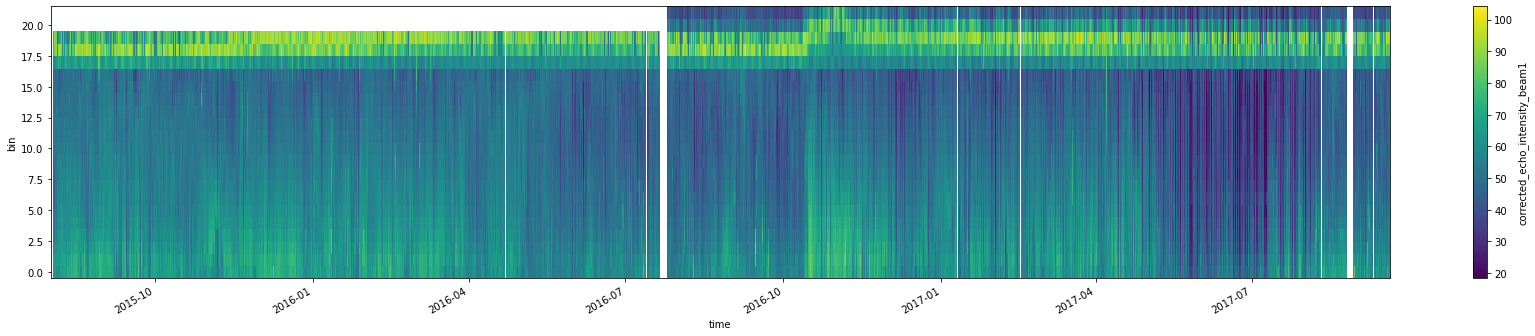

In [34]:
plt.figure(figsize=(30, 5))
da_processed.corrected_echo_intensity_beam1.T.plot()

In [35]:
da_processed

<xarray.Dataset>
Dimensions:                         (bin: 22, time: 1123200)
Coordinates:
  * bin                             (bin) int32 0 1 2 3 4 5 ... 17 18 19 20 21
  * time                            (time) datetime64[ns] 2015-08-01T08:00:00...
Data variables:
    corrected_echo_intensity_beam1  (time, bin) float64 dask.array<chunksize=(1440, 22), meta=np.ndarray>